In [1]:
import numpy as np
from time import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import pdspy.modeling as modeling
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.animation import FuncAnimation
import os
import pickle

%matplotlib inline

In [221]:
param_names = ["T_star","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]

# get all model data
with open ('../grid_metadata/corefull.txt', 'rb') as fp:
    core= pickle.load(fp)
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)
    
dictionary=np.load("../grid_metadata/dictionary.npy")

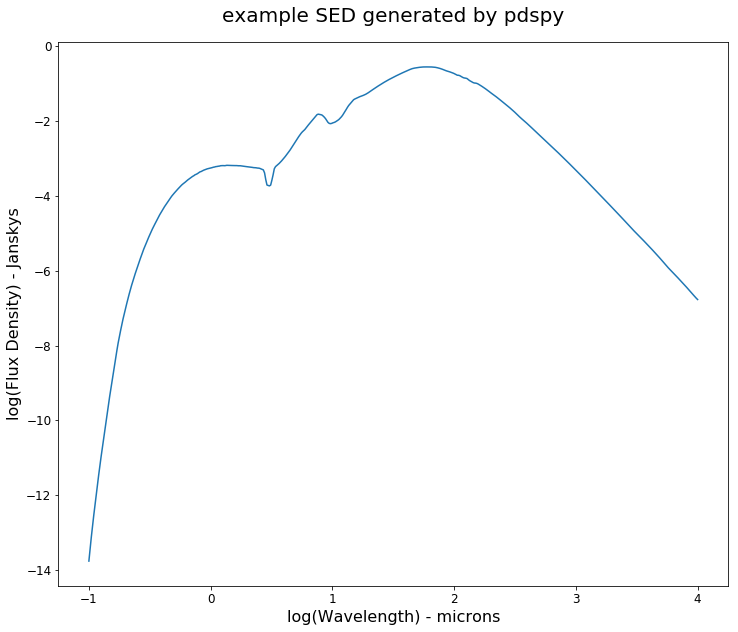

In [36]:
plt.figure(figsize=(12,10))
plt.plot(np.log10(xvals),cube[16])
plt.xlabel("log(Wavelength) - microns").set_fontsize(16)
plt.ylabel("log(Flux Density) - Janskys").set_fontsize(16)
plt.tick_params(labelsize=12)
plt.title("example SED generated by pdspy",pad=20).set_fontsize(20)
plt.show()

In [38]:
dictionary[16]

{'Tstar': 4218.751714594813,
 'logL_star': -0.8219494730537672,
 'logM_disk': -6.678976808923213,
 'logR_disk': 1.872527232441081,
 'h_0': 0.16330757481044356,
 'logR_in': -0.49760982277855625,
 'gamma': 0.6243294365074424,
 'beta': 1.083654218736818,
 'logM_env': -7.438784963711289,
 'logR_env': 2.881130921898599,
 'f_cav': 0.6154995415954266,
 'ksi': 0.7296769592070813,
 'loga_max': 4.555789974325001,
 'p': 4.279627681808531,
 'incl': 77.50844382956491,
 'filename': 'Tstar_4218.752_logLstar_-0.822_logMdisk_-6.679_logRdisk_1.873_h0_0.163_logRin_-0.498_gamma_0.624_beta_1.084_logMenv_-7.439_logRenv_2.1_fcav_0.615_ksi_0.730_logamax_4.556_p_4.280_incl_77.508.hdf5'}

In [82]:
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)

cube=cube[:,100:500]
xvals=xvals[100:500]

# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1

In [87]:
# get all model data
with open ('../grid_metadata/corefull.txt', 'rb') as fp:
    core= pickle.load(fp)[100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))[:,100:500]
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)[100:500]

# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-20]=np.nan

In [88]:
# subtracting from the seds each sample mean
seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

done in 0.104s


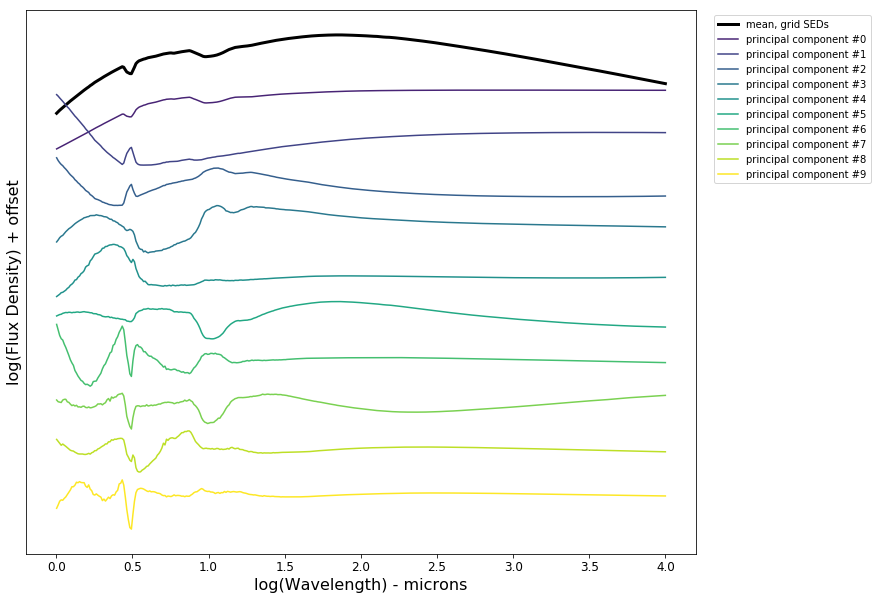

In [170]:
colors=plt.cm.viridis(np.linspace(0.1,1,10))
plt.figure(figsize=(12,10))
plt.plot(np.log10(xvals),np.mean(cube,axis=0),c='k',label="mean, grid SEDs",lw=3)
#plt.plot(np.log10(xvals),np.std(cube,axis=0),c='k',label="standard deviation, grid SEDs",linestyle="--")
for i in range(10):
    plt.plot(np.log10(xvals),(17+(15-2.5*i))*eigenseds[i]-(5*(i+1)),c=colors[i],label="principal component #"+str(i))
plt.xlabel("log(Wavelength) - microns").set_fontsize(16)
plt.ylabel("log(Flux Density) + offset").set_fontsize(16)
plt.tick_params(axis='x',labelsize=12)
plt.tick_params(axis='y',left=False,labelleft=False)
plt.legend(bbox_to_anchor=(1.02, 1))
plt.show()

In [201]:
# get all model data
with open ('../grid_metadata/corefull.txt', 'rb') as fp:
    core= pickle.load(fp)
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube2 = np.array(pickle.load(fp))
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)

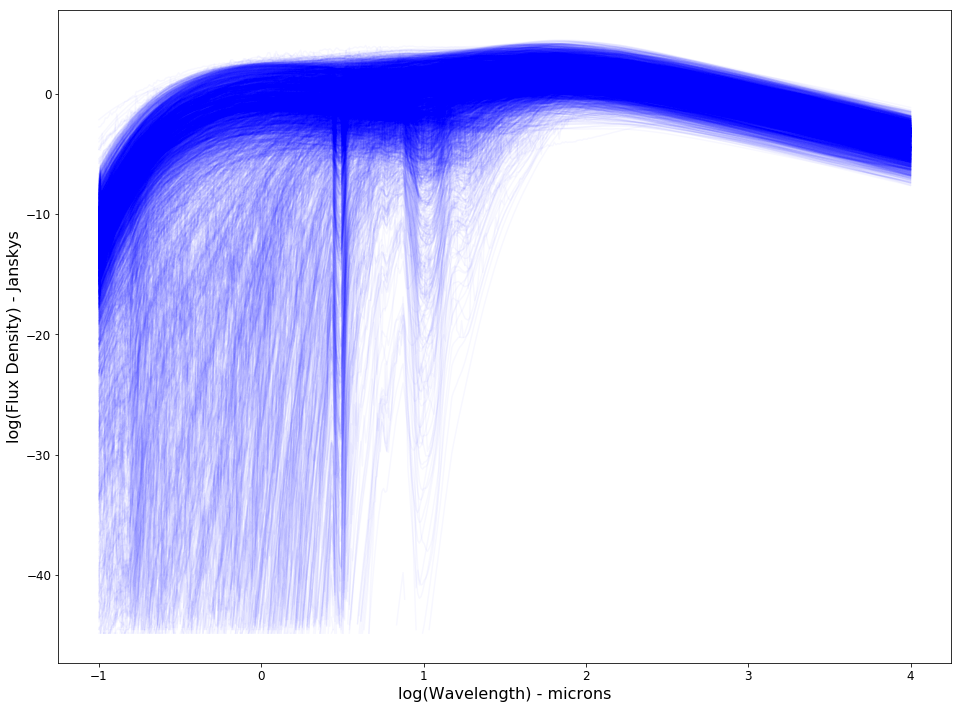

In [185]:
plt.figure(figsize=(16,12))
for i in range(3850):
    plt.plot(np.log10(xvals),cube[i],c='b',alpha=0.03)
plt.xlabel("log(Wavelength) - microns").set_fontsize(16)
plt.ylabel("log(Flux Density) - Janskys").set_fontsize(16)
plt.tick_params(labelsize=12)
plt.show()

{'Tstar': 3318.3473905871806, 'logL_star': 0.6701565256060886, 'logM_disk': -7.030662855060957, 'logR_disk': 2.4494127440128395, 'h_0': 0.11090964441687287, 'logR_in': 1.9901760907363384, 'gamma': 0.2973489283532374, 'beta': 0.9213307772409279, 'logM_env': -2.571210784254651, 'logR_env': 2.7150692271270547, 'f_cav': 0.8011126009928704, 'ksi': 1.3253854814624968, 'loga_max': 4.187145571315856, 'p': 4.0843798325231075, 'incl': 27.758475665055528, 'filename': 'Tstar_3318.347_logLstar_0.670_logMdisk_-7.031_logRdisk_2.449_h0_0.111_logRin_1.990_gamma_0.297_beta_0.921_logMenv_-2.571_logRenv_2.715_fcav_0.801_ksi_1.325_logamax_4.187_p_4.084_incl_27.758.hdf5'}


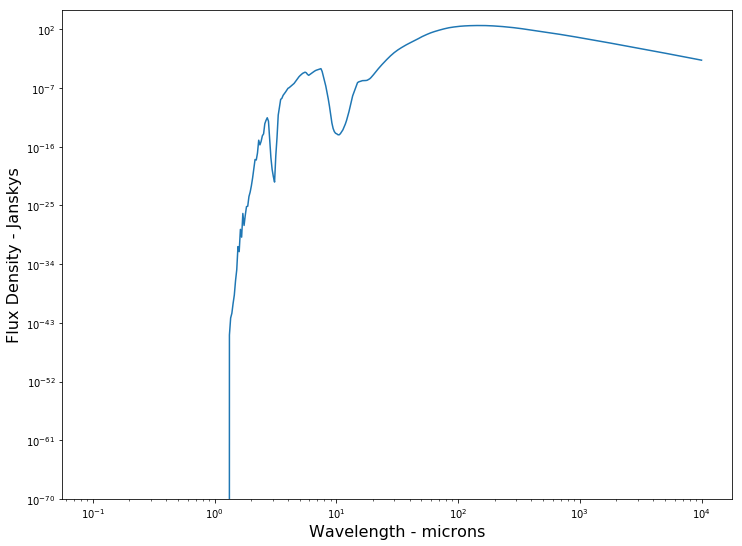

{'Tstar': 4653.052320462147, 'logL_star': -0.38313598559255224, 'logM_disk': -3.9982899617848933, 'logR_disk': 1.477518043030409, 'h_0': 0.26805487811100126, 'logR_in': 1.0160353421339083, 'gamma': 0.7609600748069223, 'beta': 1.484156479744052, 'logM_env': -2.827779377052461, 'logR_env': 3.0432237200010728, 'f_cav': 0.17901442582888663, 'ksi': 1.2612675781233866, 'loga_max': 3.0093868714830756, 'p': 2.8765979773631263, 'incl': 54.07393421654388, 'filename': 'Tstar_4653.052_logLstar_-0.383_logMdisk_-3.998_logRdisk_1.478_h0_0.268_logRin_1.016_gamma_0.761_beta_1.484_logMenv_-2.828_logRenv_3.043_fcav_0.179_ksi_1.261_logamax_3.009_p_2.877_incl_54.074.hdf5'}


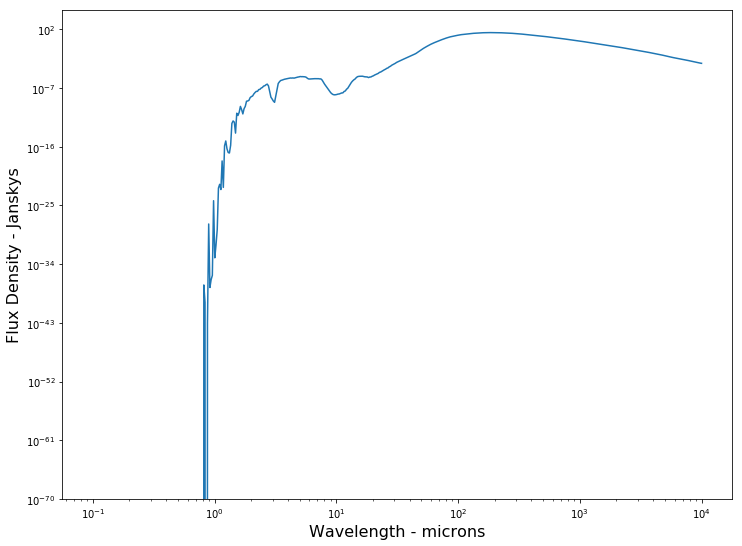

{'Tstar': 3875.6024495325128, 'logL_star': -0.286356122766379, 'logM_disk': -7.010476121905973, 'logR_disk': 1.5754557663058746, 'h_0': 0.06554743720889154, 'logR_in': 0.8851976919172846, 'gamma': 1.7425474165794055, 'beta': 1.4273555614286817, 'logM_env': -2.337718437545015, 'logR_env': 3.347197460760028, 'f_cav': 0.5194372001466184, 'ksi': 0.8544045653579171, 'loga_max': 4.309570394290153, 'p': 3.4162470052533545, 'incl': 41.3876148536699, 'filename': 'Tstar_3875.602_logLstar_-0.286_logMdisk_-7.010_logRdisk_1.575_h0_0.0_logRin_0.5_gamma_1.743_beta_1.427_logMenv_-2.338_logRenv_3.347_fcav_0.519_ksi_0.854_logamax_4.310_p_3.416_incl_41.3.hdf5'}


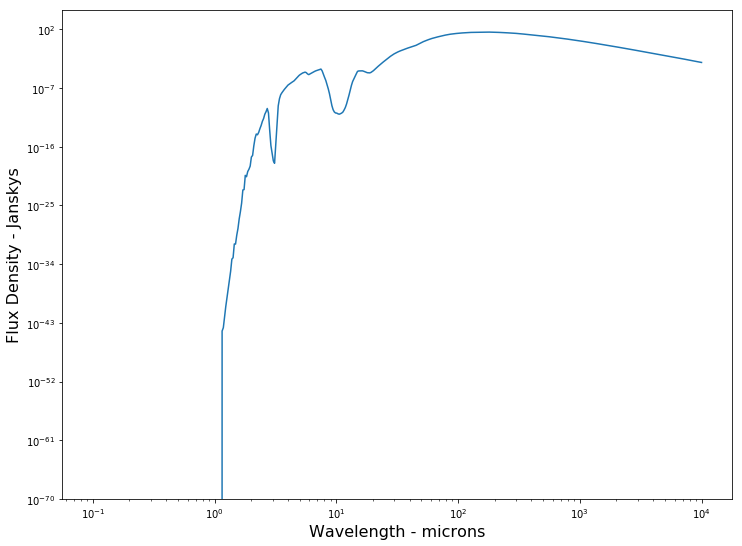

{'Tstar': 4442.177853674833, 'logL_star': 0.9244648041801686, 'logM_disk': -2.113535602945399, 'logR_disk': 2.7426061532365114, 'h_0': 0.46964698613873407, 'logR_in': 1.6939752968033126, 'gamma': 0.7306880824988131, 'beta': 1.1165998708546157, 'logM_env': -2.371460684835072, 'logR_env': 2.9444657686671265, 'f_cav': 0.385592826962642, 'ksi': 1.208056280308353, 'loga_max': 3.291410078826737, 'p': 3.1463347662969974, 'incl': 15.43226660442933, 'filename': 'Tstar_4442.178_logLstar_0.924_logMdisk_-2.114_logRdisk_2.743_h0_0.470_logRin_1.694_gamma_0.731_beta_1.117_logMenv_-2.371_logRenv_2.944_fcav_0.386_ksi_1.208_logamax_3.291_p_3.146_incl_15.432.hdf5'}


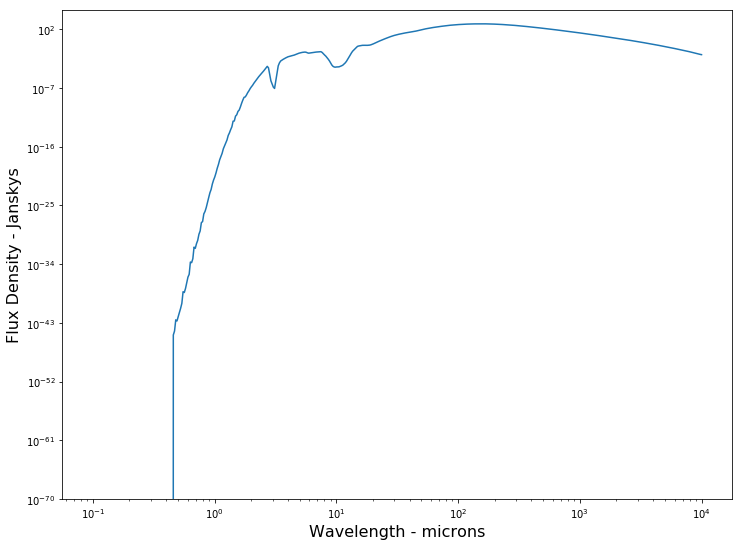

In [218]:
for i in (5,18,47,60):
    print(dictionary[i])
    plt.figure(figsize=(12,9))
    plt.loglog(xvals,10**cube2[i])
    plt.ylim(1e-70,1e5)
    plt.ylabel("Flux Density - Janskys",fontsize=16)
    plt.xlabel("Wavelength - microns",fontsize=16)
    plt.show()

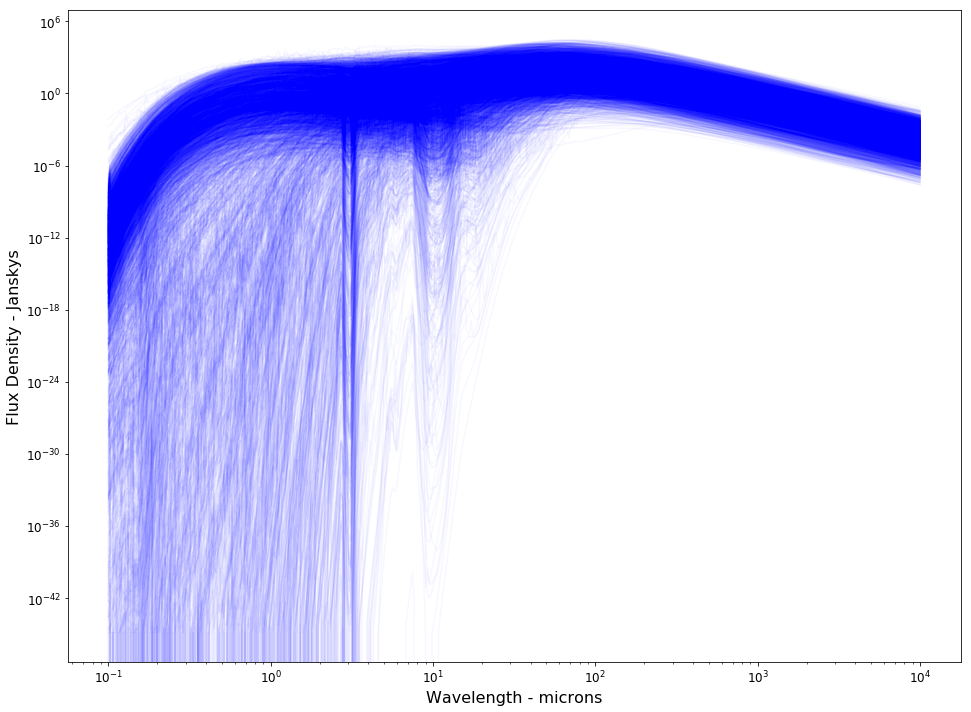

In [220]:
plt.figure(figsize=(16,12))
for i in range(3850):
    plt.loglog(xvals,10**cube[i],c='b',alpha=0.03)
plt.xlabel("Wavelength - microns").set_fontsize(16)
plt.ylabel("Flux Density - Janskys").set_fontsize(16)
plt.tick_params(labelsize=12)
plt.show()

In [222]:
inf=[]
for i in range(3850):
    if -np.inf in cube[i]:
        inf.append(i)

In [235]:
dictionary[1]['logM_env']

-5.632317811373863

In [237]:
pars=[]
for j in range(len(param_names)):
    pars.append([])
    for i in range(len(inf)):
        pars[j].append(dictionary[i][param_names[4]])
        

In [240]:
np.array(pars).shape

(15, 719)